In [33]:
%matplotlib inline
from __future__ import division
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import zscale

from weak_sauce.movers import UniformIlluminationMover
from weak_sauce.fit_flat import FlatFitter
from weak_sauce.sources import Source
from weak_sauce.grid import MoveableGrid

In [40]:
hdulist = fits.open('../data/masterFlat.fits.fz') #not in repo--need to put in local install's data dir

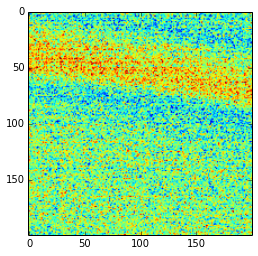

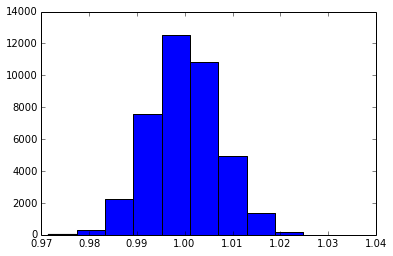

In [35]:
img = hdulist[1].data[900:1100,1400:1600]
img = img/np.mean(img)
[low,high] = zscale.zscale(img)
plt.imshow(img,vmin=low,vmax=high)
plt.figure()
_ = plt.hist(img.flatten())
data_rel_flux_map = img

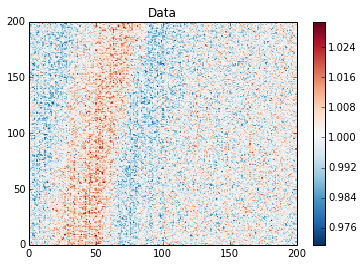

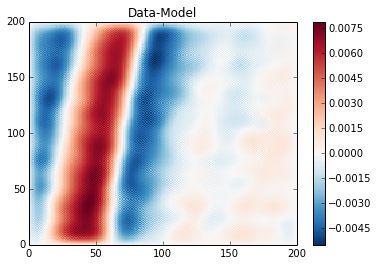

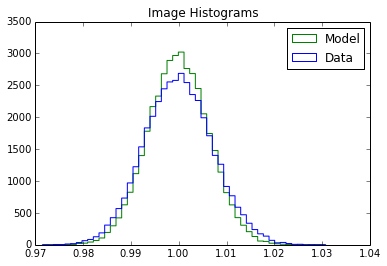

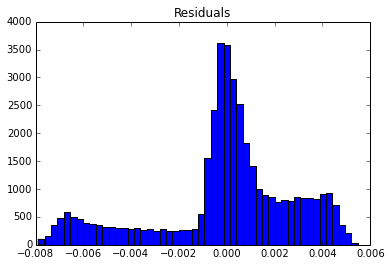

In [36]:
data_like_mover = UniformIlluminationMover()
data_like_source = Source(num_x=201) 
data_like_source.fluxes += 1 #fit to flat field
data_mg = MoveableGrid(data_like_source,data_like_mover)
fitter = FlatFitter(data_rel_flux_map, luminosity=1)
oldlnlike = -10000
lnlike = -10000
for stepnum in xrange(20000):
    fitter(data_mg.source, step_size=1e-3)
    lnlike, oldlnlike = fitter.lnlike(data_mg.source.vertices, data_mg.source.fluxes), lnlike
    if lnlike < oldlnlike:
        break
data_mg.source.plot(data_rel_flux_map, pcolormesh_kwargs_in={'linewidths':0})
plt.title('Data')
data_mg.source.plot(data_rel_flux_map - data_mg.source.fluxes, pcolormesh_kwargs_in={'linewidths':0})
plt.title('Data-Model')
plt.figure()
plt.title('Image Histograms')
_ = plt.hist([data_rel_flux_map.flatten(), data_mg.source.fluxes.flatten()],
             bins=50, histtype='step',label=['Data','Model'])
plt.legend()
plt.figure()
plt.title('Residuals')
_ = plt.hist((data_mg.source.fluxes - data_rel_flux_map).flatten(),bins=50)

Hmm, this DES flat (no detrending, 4x larger than the LSST flat) doesn't fit very well at all... Possible explanations:

* According to the FITS header, the masterFlat is composed of only 10 coadded flats, so shot noise may be preventing the convergence of the model. However, if this were the case, we'd expect a speckled pattern in the residual, which we don't.

* Maybe it needs more steps to converge/smaller step size? Maybe, but improvement from 10k steps to 20k steps was marginal...

In [39]:
from weak_sauce.data_tools import makeCorr
_ = makeCorr(img)

[[  21.    20.4   21.6   20.2   20.1]
 [  19.6   24.1   34.3   24.5   19.9]
 [  26.8   42.2  100.    42.2   26.8]
 [  19.9   24.5   34.3   24.1   19.6]
 [  20.1   20.2   21.6   20.4   21. ]]


ValueError: data mapping points must have x in increasing order

The DES flat has very different correlation structure: TBC...